In [8]:
%load_ext autoreload
%autoreload 2
import networkx as nx
import matplotlib.pyplot as plt
import random
import json

#from pcc_implementacao import *
import pandas as pd
import plotly.express as px
from sklearn.neighbors import NearestNeighbors
import numpy as np

from model import *
import torch
from torch_geometric.datasets import Planetoid
from torch_geometric.utils import to_networkx
from networkx.readwrite import json_graph
from collections import defaultdict
from model import PULearningPC, ParticleCompetitionModel
from aux import * 
from generate_dataset import *
from sklearn.metrics import f1_score


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# KARATE CLUB DATASET

/home/hem/Documents/pessoal/mestrado_material/env/lib/python3.10/site-packages/networkx/drawing/nx_pylab.py:457: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  node_collection = ax.scatter(


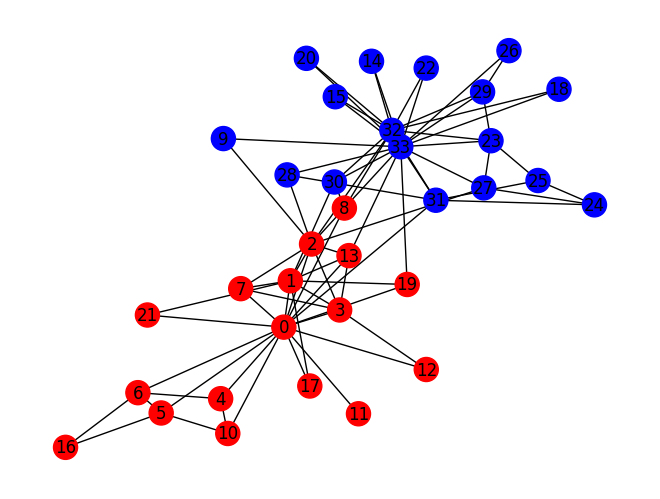

In [21]:
g_karate = nx.karate_club_graph()
club_labels = [g_karate.nodes[n]['club'] for n in g_karate.nodes()]
# Convert to numerical values (0 for 'Mr. Hi', 1 for 'Officer')
color_map = ['red' if club == 'Mr. Hi' else 'blue' for club in club_labels]

# Draw the graph
nx.draw(g_karate, node_color=color_map, with_labels=True, cmap=plt.cm.Set1)
plt.show()

## ROTULAGEM

In [6]:
g_karate_05 = prepare_pu_graph_data(g_karate, 
                                  percentage_labeled=0.5, 
                                  positive_class='Mr. Hi', 
                                  feature_class='club', 
                                  random_seed=42)

In [7]:
get_percentages_labels_graph(g_karate, 
                            positive_class='Mr. Hi', 
                            feature_class='club')

(0.5, 0.5)

In [8]:
get_percentages_labels_graph(g_karate_05, 
                            positive_class=1, 
                            feature_class='observed_label')

(0.23529411764705882, 0.7647058823529411)

## EXECUÇAO

In [16]:
mcls_params = {'cluster_strategy': 'percentage',
               'positive_cluster_threshold': 0.1}
pcm_params = {
    'num_particles': 6,
    'average_node_potential_threshold': 0.9,
    'coverage_graph_threshold': 0.95,
    'delta_p' : 0.9,
    'initialization_strategy': 'degree_weighted'
}

model = PULearningPC(g_karate_05,
                     num_neg = 20, 
                     pcm_params=pcm_params,
                     mcls_params=mcls_params,
                     mlp_params=None)
g_res, rn = model.fit_predict()

--- Step 1: Running Label Initialization ---
Avg Potential: 0.0500 (Goal: 0.9), Coverage: 6 (Goal: 95%), Positive Cluster Found? False
Avg Potential: 0.0500 (Goal: 0.9), Coverage: 10 (Goal: 95%), Positive Cluster Found? False
Avg Potential: 0.0500 (Goal: 0.9), Coverage: 14 (Goal: 95%), Positive Cluster Found? True
Avg Potential: 0.1254 (Goal: 0.9), Coverage: 16 (Goal: 95%), Positive Cluster Found? False
Avg Potential: 0.1581 (Goal: 0.9), Coverage: 15 (Goal: 95%), Positive Cluster Found? False
Avg Potential: 0.2114 (Goal: 0.9), Coverage: 16 (Goal: 95%), Positive Cluster Found? True
Avg Potential: 0.2416 (Goal: 0.9), Coverage: 16 (Goal: 95%), Positive Cluster Found? True
Avg Potential: 0.2422 (Goal: 0.9), Coverage: 16 (Goal: 95%), Positive Cluster Found? True
Avg Potential: 0.2359 (Goal: 0.9), Coverage: 15 (Goal: 95%), Positive Cluster Found? True
Avg Potential: 0.2855 (Goal: 0.9), Coverage: 16 (Goal: 95%), Positive Cluster Found? True
Avg Potential: 0.3066 (Goal: 0.9), Coverage: 17 (Goa

In [22]:
pc = ParticleCompetitionModel(g_karate_05, 
                              num_particles=4,                               
                              average_node_potential_threshold=0.9,
                              coverage_graph_threshold=0.95,
                              p_det = 0.9,
                            initialization_strategy='random')
g_res = pc.run_simulation()

Avg Potential: 0.0500 (Goal: 0.9), Coverage: 4 (Goal: 95%), Positive Cluster Found? False
Avg Potential: 0.0500 (Goal: 0.9), Coverage: 6 (Goal: 95%), Positive Cluster Found? False
Avg Potential: 0.0500 (Goal: 0.9), Coverage: 6 (Goal: 95%), Positive Cluster Found? False
Avg Potential: 0.0500 (Goal: 0.9), Coverage: 9 (Goal: 95%), Positive Cluster Found? False
Avg Potential: 0.0724 (Goal: 0.9), Coverage: 11 (Goal: 95%), Positive Cluster Found? False
Avg Potential: 0.1081 (Goal: 0.9), Coverage: 11 (Goal: 95%), Positive Cluster Found? False
Avg Potential: 0.1434 (Goal: 0.9), Coverage: 12 (Goal: 95%), Positive Cluster Found? True
Avg Potential: 0.2092 (Goal: 0.9), Coverage: 14 (Goal: 95%), Positive Cluster Found? True
Avg Potential: 0.2642 (Goal: 0.9), Coverage: 14 (Goal: 95%), Positive Cluster Found? True
Avg Potential: 0.2734 (Goal: 0.9), Coverage: 14 (Goal: 95%), Positive Cluster Found? True
Avg Potential: 0.3032 (Goal: 0.9), Coverage: 14 (Goal: 95%), Positive Cluster Found? True
Avg Pote

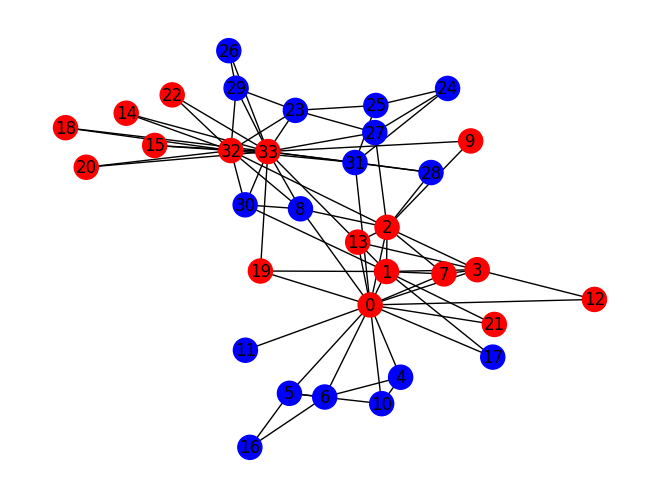

In [20]:
cluster_labels = [g_res.nodes[n]['cluster_positive'] for n in g_res.nodes()]
# Convert to numerical values (0 for 'Mr. Hi', 1 for 'Officer')
color_map = ['blue' if cluster == 0 else 'red' for cluster in cluster_labels]

# Draw the graph
nx.draw(g_res, node_color=color_map, with_labels=True)
plt.show()

## AVALIAÇAO DA INFERENCIA DE NEGATIVOS CONFIAVEIS

# CORA DATASET

In [82]:
cora_graph = load_cora_scar(
    # Change the mode here
    k = 3, 
    positive_class_label=3, 
    percent_positive=0.1, 
    use_original_edges=True # This must be False to build a new graph
)

Loading Cora dataset using PyTorch Geometric...
Using original graph structure.
Graph has 78 connected components. Connecting them using MST...
Graph is now fully connected with 2708 nodes and 5355 edges.
Cora graph loaded: 2708 nodes, 5355 edges.


In [83]:
nx.is_connected(cora_graph)

True

In [84]:
max(cora_graph.nodes)

2707

In [60]:
cora_graph.nodes(data=True)

NodeDataView({0: {'features': array([0., 0., 0., ..., 0., 0., 0.], shape=(1433,), dtype=float32), 'true_label': np.int64(3), 'observed_label': np.int64(0)}, 1: {'features': array([0., 0., 0., ..., 0., 0., 0.], shape=(1433,), dtype=float32), 'true_label': np.int64(4), 'observed_label': np.int64(0)}, 2: {'features': array([0., 0., 0., ..., 0., 0., 0.], shape=(1433,), dtype=float32), 'true_label': np.int64(4), 'observed_label': np.int64(0)}, 4: {'features': array([0., 0., 0., ..., 0., 0., 0.], shape=(1433,), dtype=float32), 'true_label': np.int64(3), 'observed_label': np.int64(0)}, 5: {'features': array([0., 0., 0., ..., 0., 0., 0.], shape=(1433,), dtype=float32), 'true_label': np.int64(2), 'observed_label': np.int64(0)}, 6: {'features': array([0., 0., 0., ..., 0., 0., 0.], shape=(1433,), dtype=float32), 'true_label': np.int64(0), 'observed_label': np.int64(0)}, 8: {'features': array([0., 0., 0., ..., 0., 0., 0.], shape=(1433,), dtype=float32), 'true_label': np.int64(3), 'observed_label':

In [85]:
cora_graph.number_of_nodes()

2708

In [94]:
mcls_params = {'cluster_strategy': 'percentage',
               'positive_cluster_threshold': 0.2}
pcm_params = {
    'num_particles': 387,
    'average_node_potential_threshold': 0.7,
    'delta_p' : 0.8,
    'initialization_strategy': 'random'
}

model = PULearningPC(cora_graph,
                     num_neg = 100, 
                     pcm_params=pcm_params,
                     mcls_params=mcls_params,
                     mlp_params=None)
g_res, rn = model.fit_predict()
rn

--- Step 1: Running Label Initialization ---
Avg Potential: 0.0500 (Goal: 0.7), Coverage: 12.37% (Goal: 80%), Positive Cluster Found? False
Avg Potential: 0.0500 (Goal: 0.7), Coverage: 21.05% (Goal: 80%), Positive Cluster Found? False
Avg Potential: 0.0621 (Goal: 0.7), Coverage: 27.33% (Goal: 80%), Positive Cluster Found? True
Avg Potential: 0.0933 (Goal: 0.7), Coverage: 30.72% (Goal: 80%), Positive Cluster Found? True
Avg Potential: 0.1239 (Goal: 0.7), Coverage: 33.79% (Goal: 80%), Positive Cluster Found? True
Avg Potential: 0.1558 (Goal: 0.7), Coverage: 34.97% (Goal: 80%), Positive Cluster Found? True
Avg Potential: 0.1840 (Goal: 0.7), Coverage: 37.15% (Goal: 80%), Positive Cluster Found? True
Avg Potential: 0.2183 (Goal: 0.7), Coverage: 39.40% (Goal: 80%), Positive Cluster Found? True
Avg Potential: 0.2498 (Goal: 0.7), Coverage: 41.51% (Goal: 80%), Positive Cluster Found? True
Avg Potential: 0.2768 (Goal: 0.7), Coverage: 43.46% (Goal: 80%), Positive Cluster Found? True
Avg Potential

[1208,
 84,
 583,
 2223,
 2226,
 187,
 2462,
 75,
 284,
 1056,
 1544,
 2224,
 2225,
 2482,
 2603,
 2159,
 2298,
 1442,
 260,
 167,
 259,
 462,
 538,
 677,
 721,
 786,
 939,
 1541,
 2150,
 2222,
 2433,
 2537,
 2631,
 2602,
 23,
 1381,
 2297,
 2548,
 209,
 361,
 432,
 1449,
 2683,
 1559,
 365,
 1556,
 1036,
 66,
 117,
 168,
 247,
 287,
 380,
 431,
 774,
 917,
 930,
 953,
 954,
 967,
 1005,
 1032,
 1034,
 1048,
 1181,
 1233,
 1286,
 1673,
 2058,
 2173,
 2341,
 2429,
 2432,
 2566,
 2567,
 2569,
 2586,
 2619,
 2666,
 2694,
 653,
 140,
 488,
 582,
 798,
 1794,
 1796,
 2299,
 2547,
 273,
 509,
 846,
 1101,
 1242,
 1597,
 2681,
 283,
 1260,
 614,
 888]

In [93]:
rn

[2622,
 144,
 213,
 127,
 145,
 1165,
 1593,
 2454,
 2604,
 92,
 1504,
 1836,
 2209,
 537,
 495,
 26,
 99,
 122,
 123,
 832,
 1208,
 108,
 2158,
 898,
 1835,
 1698,
 1328,
 84,
 2223,
 2226,
 31,
 187,
 2455,
 2600,
 2157,
 2160,
 284,
 1056,
 2224,
 2225,
 2482,
 2603,
 307,
 2159,
 167,
 462,
 538,
 1263,
 2222,
 2437,
 2438,
 2631,
 2602,
 23,
 209,
 1559,
 1793,
 1686,
 3,
 12,
 66,
 106,
 117,
 168,
 225,
 1048,
 1286,
 1393,
 1407,
 2341,
 2662,
 2687,
 2688,
 653,
 1575,
 163,
 2681,
 140,
 283,
 488,
 798,
 1260,
 2496,
 2547,
 217,
 2474,
 2647,
 7,
 184,
 780,
 821,
 1001,
 1371,
 1554,
 2255,
 2618,
 782,
 473,
 2646,
 941]

In [ ]:
cora_graph.nodes('true_label')

np.int64(1)

In [66]:
y_true = [1 if n[1] == 3 else 0 for n in cora_graph.nodes('true_label')]

In [71]:
y = dict(zip(nodes_list, y_true))

In [95]:
y_true_f1 = [cora_graph.nodes[n]['true_label'] for n in rn]
y_pred = [0] * len(rn)
f1_score(y_true_f1, y_pred, pos_label = 0)

0.8304093567251462

# CITESEER

In [13]:
g_citeseer = load_citeseer_scar(
    positive_class_label=2,
    percent_positive=0.1,
    use_original_edges=True  # This must be False to build a new graph
    )

Loading CiteSeer dataset using PyTorch Geometric...
Using original graph structure.
CiteSeer graph loaded: 2120 nodes, 3679 edges.


In [12]:
nx.is_connected(g_citeseer)

True

In [76]:
mcls_params = {'cluster_strategy': 'percentage',
               'positive_cluster_threshold': 0.1}
pcm_params = {
    'num_particles': 387,
    'average_node_potential_threshold': 0.7,
    'coverage_graph_threshold': 0.7,
    'delta_p' : 0.8,
    'initialization_strategy': 'random'
}

model = PULearningPC(g_citeseer,
                     num_neg = 200, 
                     pcm_params=pcm_params,
                     mcls_params=mcls_params,
                     mlp_params=None)
g_res_seer, rn_seer = model.fit_predict()
rn_seer

--- Step 1: Running Label Initialization ---
Avg Potential: 0.0500 (Goal: 0.7), Coverage: 16.46% (Goal: 70%), Positive Cluster Found? False
Avg Potential: 0.0500 (Goal: 0.7), Coverage: 29.62% (Goal: 70%), Positive Cluster Found? False
Avg Potential: 0.0780 (Goal: 0.7), Coverage: 38.77% (Goal: 70%), Positive Cluster Found? False
Avg Potential: 0.1305 (Goal: 0.7), Coverage: 43.77% (Goal: 70%), Positive Cluster Found? False
Avg Potential: 0.1841 (Goal: 0.7), Coverage: 47.64% (Goal: 70%), Positive Cluster Found? False
Avg Potential: 0.2287 (Goal: 0.7), Coverage: 50.09% (Goal: 70%), Positive Cluster Found? False
Avg Potential: 0.2661 (Goal: 0.7), Coverage: 52.08% (Goal: 70%), Positive Cluster Found? False
Avg Potential: 0.2973 (Goal: 0.7), Coverage: 53.44% (Goal: 70%), Positive Cluster Found? False
Avg Potential: 0.3272 (Goal: 0.7), Coverage: 54.86% (Goal: 70%), Positive Cluster Found? False
Avg Potential: 0.3499 (Goal: 0.7), Coverage: 55.75% (Goal: 70%), Positive Cluster Found? False
Avg P

[260,
 1882,
 2552,
 2749,
 1577,
 2748,
 1001,
 2831,
 2747,
 1356,
 600,
 3022,
 2570,
 726,
 498,
 1544,
 2629,
 1762,
 418,
 743,
 871,
 2103,
 2105,
 3069,
 1610,
 3305,
 791,
 3167,
 57,
 1140,
 22,
 100,
 2158,
 3157,
 1252,
 2652,
 956,
 1022,
 1271,
 1302,
 2601,
 543,
 1990,
 2161,
 2165,
 2423,
 1320,
 2895,
 1441,
 2669,
 1207,
 1223,
 3159,
 2140,
 3110,
 3251,
 390,
 1754,
 1083,
 1468,
 1733,
 2309,
 2971,
 487,
 1026,
 1203,
 2438,
 3117,
 3118,
 3119,
 1372,
 1141,
 1151,
 1851,
 598,
 2357,
 2358,
 1461,
 407,
 2240,
 1093,
 2090,
 2424,
 2561,
 2159,
 2225,
 531,
 2611,
 938,
 2603,
 932,
 990,
 3019,
 3108,
 357,
 999,
 1407,
 1916,
 2350,
 93,
 331,
 1709,
 458,
 1867,
 2007,
 1288,
 1084,
 1123,
 2012,
 2334,
 1780,
 2142,
 3062,
 3067,
 126,
 1017,
 1641,
 2953,
 1571,
 2930,
 1841,
 226,
 700,
 1241,
 1847,
 2412,
 3125,
 1887,
 1409,
 87,
 2215,
 2918,
 971,
 1263,
 1983,
 1364,
 940,
 3212,
 2425,
 2949,
 191,
 2104,
 578,
 3277,
 2610,
 447,
 1667,
 779,
 132

In [78]:
g_citeseer.nodes('true_label')

NodeDataView({1: np.int64(1), 5: np.int64(1), 8: np.int64(3), 10: np.int64(2), 12: np.int64(2), 13: np.int64(1), 16: np.int64(2), 17: np.int64(4), 18: np.int64(4), 19: np.int64(0), 20: np.int64(1), 22: np.int64(5), 23: np.int64(3), 24: np.int64(5), 25: np.int64(2), 26: np.int64(5), 27: np.int64(2), 28: np.int64(4), 29: np.int64(2), 30: np.int64(2), 31: np.int64(2), 32: np.int64(4), 33: np.int64(5), 34: np.int64(2), 38: np.int64(3), 39: np.int64(3), 40: np.int64(2), 42: np.int64(2), 43: np.int64(1), 44: np.int64(5), 48: np.int64(2), 49: np.int64(3), 50: np.int64(3), 51: np.int64(2), 52: np.int64(5), 53: np.int64(2), 54: np.int64(5), 55: np.int64(1), 56: np.int64(4), 57: np.int64(1), 59: np.int64(2), 61: np.int64(3), 62: np.int64(4), 65: np.int64(1), 66: np.int64(3), 69: np.int64(2), 70: np.int64(4), 72: np.int64(1), 75: np.int64(2), 76: np.int64(0), 77: np.int64(3), 78: np.int64(5), 79: np.int64(2), 80: np.int64(4), 81: np.int64(1), 83: np.int64(4), 84: np.int64(4), 87: np.int64(4), 88:

In [80]:
nodes_list = list(g_citeseer.nodes())
y_true = [1 if n[1] == 2 else 0 for n in g_citeseer.nodes('true_label')]
y = dict(zip(nodes_list, y_true))

In [81]:
y_true_f1 = [y[n] for n in rn_seer]
y_pred = [0] * len(rn)
f1_score(y_true_f1, y_pred, pos_label = 0)

0.9717223650385605

In [28]:
np.unique([g_citeseer.nodes[n]['observed_label'] for n in g_citeseer.nodes], return_counts=True)

(array([0, 1]), array([2067,   53]))

In [22]:
[1 if g_citeseer.nodes()[n]['observed_label'] == 1 else 0 for n in g_citeseer.nodes(data=True)]

TypeError: unhashable type: 'dict'

In [16]:
y_true = [g_citeseer.nodes[n]['observed_label'] for n in rn]
y_pred = [0] * len(rn)
f1_score(y_true, y_pred, pos_label = 0)

1.0

# TWITCH

In [25]:
twitch_g = load_twitch_scar(
    name= 'EN',
    mode='gaussian_full',
    sigma=1.0,
    percent_positive=0.1,
    use_original_edges=False  # This must be False to build a new graph
    )


Loading Twitch-EN dataset...


HTTPError: 404 Client Error: Not Found for url: https://raw.githubusercontent.com/shchur/gnn-benchmark/master/data/twitch_gamers/EN.npz

# MNIST

In [2]:
g_mnist = load_mnist_scar(
    mode='gaussian_full',
    sigma=10,
    percent_positive=0.1,
    )

A carregar o conjunto de dados MNIST...
A construir o grafo a partir das características usando o modo: gaussian_full
Grafo MNIST carregado: 5000 nós, 12497500 arestas.


In [3]:
nx.is_connected(g_mnist)

True

In [31]:
g_mnist.nodes('true_label')

NodeDataView({0: np.int64(0), 1: np.int64(0), 2: np.int64(1), 3: np.int64(0), 4: np.int64(1), 5: np.int64(1), 6: np.int64(1), 7: np.int64(0), 8: np.int64(1), 9: np.int64(0), 10: np.int64(1), 11: np.int64(0), 12: np.int64(1), 13: np.int64(1), 14: np.int64(1), 15: np.int64(0), 16: np.int64(0), 17: np.int64(1), 18: np.int64(1), 19: np.int64(0), 20: np.int64(0), 21: np.int64(0), 22: np.int64(0), 23: np.int64(1), 24: np.int64(1), 25: np.int64(1), 26: np.int64(1), 27: np.int64(1), 28: np.int64(0), 29: np.int64(1), 30: np.int64(0), 31: np.int64(0), 32: np.int64(0), 33: np.int64(1), 34: np.int64(0), 35: np.int64(1), 36: np.int64(1), 37: np.int64(0), 38: np.int64(0), 39: np.int64(1), 40: np.int64(1), 41: np.int64(0), 42: np.int64(0), 43: np.int64(1), 44: np.int64(1), 45: np.int64(0), 46: np.int64(0), 47: np.int64(1), 48: np.int64(1), 49: np.int64(0), 50: np.int64(1), 51: np.int64(0), 52: np.int64(0), 53: np.int64(0), 54: np.int64(0), 55: np.int64(1), 56: np.int64(1), 57: np.int64(1), 58: np.int

In [33]:
5000 / 4

1250.0

In [4]:
mcls_params = {'cluster_strategy': 'percentage',
               'positive_cluster_threshold': 0.2}
pcm_params = {
    'num_particles': 600,
    'average_node_potential_threshold': 0.7,
    'coverage_graph_threshold': 0.7,
    'delta_p' : 0.8,
    'initialization_strategy': 'random'
}

model = PULearningPC(g_mnist,
                     num_neg = 200, 
                     pcm_params=pcm_params,
                     mcls_params=mcls_params,
                     mlp_params=None)
g_res, rn = model.fit_predict()
rn

--- Step 1: Running Label Initialization ---
Avg Potential: 0.0500 (Goal: 0.7), Coverage: 10.76% (Goal: 70%), Positive Cluster Found? False
Avg Potential: 0.0500 (Goal: 0.7), Coverage: 19.04% (Goal: 70%), Positive Cluster Found? False
Avg Potential: 0.0500 (Goal: 0.7), Coverage: 25.90% (Goal: 70%), Positive Cluster Found? True
Avg Potential: 0.0729 (Goal: 0.7), Coverage: 32.66% (Goal: 70%), Positive Cluster Found? True
Avg Potential: 0.1118 (Goal: 0.7), Coverage: 36.68% (Goal: 70%), Positive Cluster Found? True
Avg Potential: 0.1502 (Goal: 0.7), Coverage: 39.48% (Goal: 70%), Positive Cluster Found? True
Avg Potential: 0.1895 (Goal: 0.7), Coverage: 42.40% (Goal: 70%), Positive Cluster Found? True
Avg Potential: 0.2271 (Goal: 0.7), Coverage: 44.78% (Goal: 70%), Positive Cluster Found? True
Avg Potential: 0.2681 (Goal: 0.7), Coverage: 47.68% (Goal: 70%), Positive Cluster Found? True
Avg Potential: 0.2996 (Goal: 0.7), Coverage: 49.32% (Goal: 70%), Positive Cluster Found? True
Avg Potential

KeyboardInterrupt: 